# 1. 자율주행 시스템 만들기

In [62]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def self_drive_assist(img_path, size_limit=300,is_visual=False):
    # Load and preprocess the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    ratio = ratio.numpy()
    
    detections = inference_model(input_image)
    num_detections = int(detections.valid_detections[0])
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    classes = detections.nmsed_classes[0][:num_detections].numpy().astype(int)
    scores = detections.nmsed_scores[0][:num_detections].numpy()
    
    class_id_to_name = {
        0: 'Car',
        1: 'Van',
        2: 'Truck',
        3: 'Pedestrian',
        4: 'Person_sitting',
        5: 'Cyclist',
        6: 'Tram',
        7: 'Misc'
    }
    class_names = [class_id_to_name.get(cls, 'Unknown') for cls in classes]
    
    if is_visual == True:
        visualize_detections(
            image,
            detections.nmsed_boxes[0][:num_detections] / ratio,
            class_names,
            detections.nmsed_scores[0][:num_detections],
        )
    
    for i in range(num_detections):
        class_name = class_names[i]
        box = boxes[i]
        x1, y1, x2, y2 = box 
        width = x2 - x1
        height = y2 - y1

        if class_name in ["Pedestrian", "Person_sitting", "Cyclist"]:
            return "Stop"
        elif class_name in ["Car", "Van", "Truck", "Tram"]:
            if width >= size_limit or height >= size_limit:
                return "Stop"
    
    return "Go"

# 2. 자율주행 시스템 평가하기

In [65]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

### 학습전

In [64]:
model_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'checkpoints')
checkpoint_path = os.path.join(model_dir, 'weights_1.h5')
model.load_weights(checkpoint_path)

test_system(self_drive_assist)

50점입니다.


### 학습 후 

In [66]:
model_dir = os.path.join(os.getenv('HOME'), 'aiffel', 'object_detection', 'checkpoints')
checkpoint_path = os.path.join(model_dir, 'weights_17.h5')
model.load_weights(checkpoint_path)

test_system(self_drive_assist)

100점입니다.


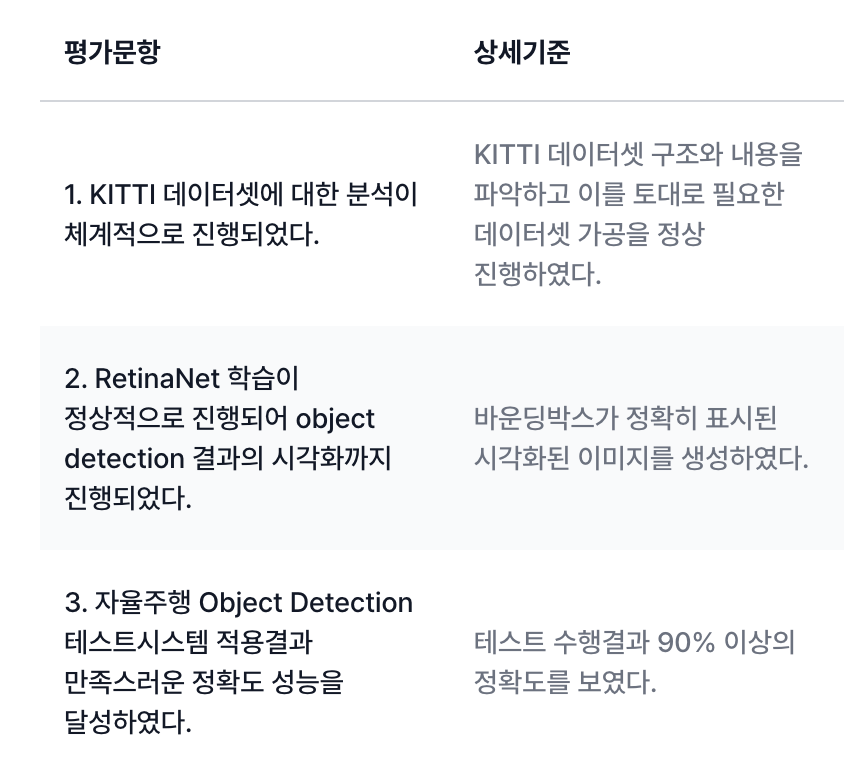

# 1. KITTI 데이터셋 분석

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

print('슝=3')

슝=3


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


In [3]:
ds_train

<_OptionsDataset shapes: {image: (None, None, 3), image/file_name: (), objects: {alpha: (None,), bbox: (None, 4), dimensions: (None, 3), location: (None, 3), occluded: (None,), rotation_y: (None,), truncated: (None,), type: (None,)}}, types: {image: tf.uint8, image/file_name: tf.string, objects: {alpha: tf.float32, bbox: tf.float32, dimensions: tf.float32, location: tf.float32, occluded: tf.int64, rotation_y: tf.float32, truncated: tf.float32, type: tf.int64}}>

In [13]:
# 데이터셋의 특징을 좀 더 자세히 확인
for sample in ds_train.take(1):
    # 전체 샘플 출력
#     print("전체 샘플 데이터 구조:\n", sample)

    # 이미지 정보 확인
    print("\n이미지 정보:")
    print("Shape:", sample["image"].shape)
    print("Type:", sample["image"].dtype)

    # 이미지 파일 이름 확인
    print("\n이미지 파일 이름:")
    print(sample["image/file_name"].numpy())
    
    print("\n이미지 객체:")    
    print(sample["objects"])      


이미지 정보:
Shape: (375, 1242, 3)
Type: <dtype: 'uint8'>

이미지 파일 이름:
b'005486.png'

이미지 객체:
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([ 2.02,  1.17,  1.76,  1.43,  1.68, -1.63, -1.62], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.00266667, 0.00683575, 0.53573334, 0.33022544],
       [0.00266667, 0.6232045 , 0.46514666, 0.99919486],
       [0.32930666, 0.32613528, 0.5345067 , 0.40726247],
       [0.37250668, 0.54978263, 0.52029335, 0.61419487],
       [0.40573335, 0.38175523, 0.5354933 , 0.4366908 ],
       [0.46130666, 0.525153  , 0.53736   , 0.55117553],
       [0.48546666, 0.51616746, 0.57794666, 0.54144925]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.56, 1.68, 3.69],
       [1.44, 1.64, 4.5 ],
       [1.46, 1.51, 3.24],
       [1.38, 1.59, 4.19],
       [1.38, 1.69, 3.74],
       [1.51, 1.56, 3.81],
       [2.38, 1.98, 5.62]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dt

In [6]:
ds_test

<_OptionsDataset shapes: {image: (None, None, 3), image/file_name: (), objects: {alpha: (None,), bbox: (None, 4), dimensions: (None, 3), location: (None, 3), occluded: (None,), rotation_y: (None,), truncated: (None,), type: (None,)}}, types: {image: tf.uint8, image/file_name: tf.string, objects: {alpha: tf.float32, bbox: tf.float32, dimensions: tf.float32, location: tf.float32, occluded: tf.int64, rotation_y: tf.float32, truncated: tf.float32, type: tf.int64}}>

In [14]:
# 데이터셋의 특징을 좀 더 자세히 확인
for sample in ds_test.take(1):
    # 전체 샘플 출력
    print("전체 샘플 데이터 구조:\n", sample)

    # 이미지 정보 확인
    print("\n이미지 정보:")
    print("Shape:", sample["image"].shape)
    print("Type:", sample["image"].dtype)

    # 이미지 파일 이름 확인
    print("\n이미지 파일 이름:")
    print(sample["image/file_name"].numpy())

    print("\n이미지 객체:")    
    print(sample["objects"])      


전체 샘플 데이터 구조:
 {'image': <tf.Tensor: shape=(375, 1242, 3), dtype=uint8, numpy=
array([[[ 53,  94,  69],
        [ 56,  90,  29],
        [ 60,  72,  25],
        ...,
        [188, 255, 255],
        [182, 255, 255],
        [164, 255, 255]],

       [[ 54,  72,  37],
        [ 54,  71,  40],
        [ 60,  68,  37],
        ...,
        [177, 255, 253],
        [161, 255, 247],
        [130, 251, 246]],

       [[ 44,  62,  34],
        [ 42,  62,  41],
        [ 59,  61,  43],
        ...,
        [163, 246, 236],
        [150, 242, 223],
        [144, 228, 229]],

       ...,

       [[ 22,  21,  21],
        [ 19,  20,  21],
        [ 16,  18,  20],
        ...,
        [ 26,  28,  32],
        [ 24,  27,  33],
        [ 22,  26,  30]],

       [[ 16,  17,  16],
        [ 16,  16,  19],
        [ 15,  16,  21],
        ...,
        [ 25,  26,  29],
        [ 23,  26,  29],
        [ 20,  25,  30]],

       [[ 14,  16,  15],
        [ 14,  16,  19],
        [ 14,  15,  21],
        

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.96], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.42341334, 0.31099838, 0.5110667 , 0.38967794]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.47, 1.74, 4.26]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-8.3 ,  2.  , 34.36]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.09], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


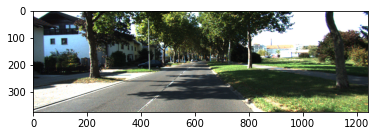

In [17]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

In [25]:
objects.keys()

dict_keys(['alpha', 'bbox', 'dimensions', 'location', 'occluded', 'rotation_y', 'truncated', 'type'])

In [27]:
objects['type']

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

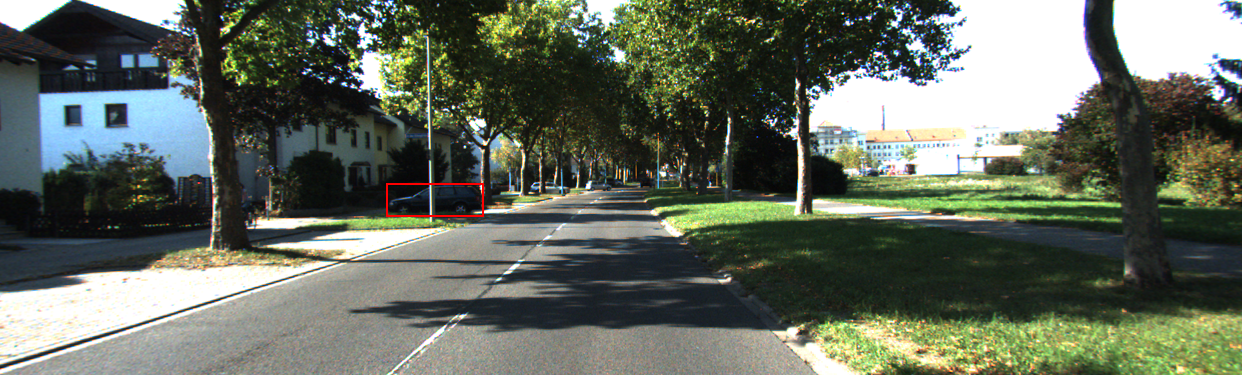

In [20]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    # [[YOUR CODE]]
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    # [[YOUR CODE]]
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)


    return input_image

visualize_bbox(img, objects['bbox'].numpy())

# 데이터 준비

In [31]:
'''
(y_min, x_min, y_max, x_max) 를
(x_min, y_min, x_max, y_max) 형식으로 바꿉니다.
'''
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [32]:
'''
데이터 증강(Data Augmentation)을 통해 모델의 일반화를 돕기 위해 사용
'''
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [33]:
'''
이미지의 최소 길이를 min_side로 맞추고, 
최대 길이는 max_side를 넘지 않도록 조절합니다. 
이후, stride에 맞춰 패딩을 추가합니다.
'''

def resize_and_pad_image(image, training=True):

#     min_side = 800.0
#     max_side = 1333.0
#     min_side_range = [640, 1024]
# 학습 속도와 메모리 최적화를 위한 좋은 선택, 다만 모델의 성능에 미치는 영향
    min_side = 400.0
    max_side = 600.0
    min_side_range = [400, 1000]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')




슝=3


In [34]:
'''
바운딩 박스의 좌표를 (x_min, y_min, x_max, y_max) 형식에서 
(center_x, center_y, width, height) 형식으로 변환
'''
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0,  # 중심 좌표 (center_x, center_y)
         boxes[..., 2:] - boxes[..., :2]],        # 너비와 높이 (width, height)
        axis=-1,
    )


In [35]:
'''
데이터셋에서 샘플을 받아와 이미지와 바운딩 박스를 전처리합니다. 
이미지의 좌우 반전, 리사이즈, 패딩을 수행하고 바운딩 박스 좌표를 모델이 이해할 수 있는 형식으로 변환
'''
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')


슝=3


In [36]:
'''
다양한 크기와 비율의 앵커 박스를 특징 맵에 생성하여 객체 탐지 모델의 입력으로 사용
'''

class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    # 다양한 비율(aspect ratio)과 크기(scale)를 조합하여 앵커 박스의 크기를 계산
    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    # 지정된 레벨에 따라 특징 맵의 각 위치에 앵커 박스를 생성
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    # 전체 이미지 크기에 맞춰 모든 앵커 박스를 반환
    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


In [37]:
'''
중심 좌표 (center_x, center_y)와 (width, height) 형식으로 주어진 바운딩 박스를 
(x_min, y_min, x_max, y_max) 형식으로 변환
'''
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0,  # 왼쪽 위 모서리 (xmin, ymin)
         boxes[..., :2] + boxes[..., 2:] / 2.0], # 오른쪽 아래 모서리 (xmax, ymax)
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


In [38]:
'''
바운딩 박스의 매칭을 수행하여, 각 앵커 박스가 객체를 포함하고 있는지 여부를 결정
'''
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    # 앵커 박스와 실제 바운딩 박스의 IoU를 계산하여 매칭
    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    # 앵커 박스를 기준으로 실제 바운딩 박스를 어떻게 변환해야 할지 계산
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    # 개별 이미지에 대해 라벨을 인코딩
    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    # 배치 단위로 이미지와 바운딩 박스를 인코딩
    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


# 2. RetinaNet Model 학습 

In [44]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


In [39]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


In [40]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


- ResNet50: 비교적 무겁지만 더 나은 성능을 기대할 수 있습니다.
- MobileNetV2: 경량 모델로 빠르고 리소스가 적게 필요합니다.
- EfficientNetB0: 효율성을 높인 최신 모델로, 경량 모델이 필요할 때 적합합니다.

In [41]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


In [42]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


In [45]:
num_classes = 8
# batch_size = 2
batch_size = 4

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)


In [46]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

슝=3


In [47]:
print("Train dataset example shape:", next(iter(train_dataset))[0].shape)
print("Validation dataset example shape:", next(iter(val_dataset))[0].shape)


Train dataset example shape: (4, 256, 640, 3)
Validation dataset example shape: (1, 256, 640, 3)


In [48]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, 
                              momentum=0.9)
model.compile(loss=loss_fn, 
              optimizer=optimizer)

In [ ]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/checkpoints/'
os.makedirs(model_dir, exist_ok=True)

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_{epoch}.h5"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    ),
    
    tf.keras.callbacks.CSVLogger(
        filename = os.path.join(model_dir, 'training_log.csv'),
        separator = ',',
        append = False
    )
]

epochs = 50

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/50
1586/1586 [==============================] - 429s 261ms/step - loss: 2.6094 - val_loss: 1.8958

Epoch 00001: saving model to /aiffel/aiffel/object_detection/checkpoints/weights_1.h5
Epoch 2/50
1586/1586 [==============================] - 414s 260ms/step - loss: 1.1788 - val_loss: 1.2675

Epoch 00002: saving model to /aiffel/aiffel/object_detection/checkpoints/weights_2.h5
Epoch 3/50
1586/1586 [==============================] - 414s 260ms/step - loss: 0.7988 - val_loss: 1.0688

Epoch 00003: saving model to /aiffel/aiffel/object_detection/checkpoints/weights_3.h5
Epoch 4/50
1586/1586 [==============================] - 415s 261ms/step - loss: 0.6241 - val_loss: 0.9569

Epoch 00004: saving model to /aiffel/aiffel/object_detection/checkpoints/weights_4.h5
Epoch 5/50
1586/1586 [==============================] - 414s 261ms/step - loss: 0.5216 - val_loss: 0.9364

Epoch 00005: saving model to /aiffel/aiffel/object_detection/checkpoints/weights_5.h5
Epoch 6/50
1586/1586 [=============

    epoch      loss  val_loss
0       0  2.609391  1.895781
1       1  1.178839  1.267548
2       2  0.798770  1.068846
3       3  0.624125  0.956884
4       4  0.521617  0.936404
5       5  0.446767  0.876750
6       6  0.391600  0.933375
7       7  0.359547  0.870158
8       8  0.316102  0.871023
9       9  0.274628  0.847531
10     10  0.242506  0.895886
11     11  0.218692  0.873668
12     12  0.197416  0.877251
13     13  0.178345  0.915479
14     14  0.160513  0.896430
15     15  0.145088  0.910715
16     16  0.141793  0.876537


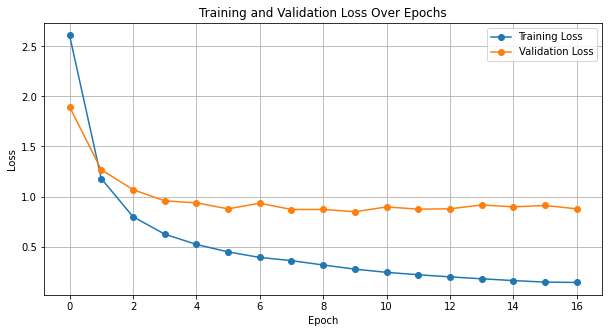

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# CSV 파일 경로 설정
model_dir = os.getenv('HOME') + '/aiffel/object_detection/checkpoints/'
csv_log_path = os.path.join(model_dir, "training_log.csv")

# CSV 파일 읽기
df = pd.read_csv(csv_log_path)

# 데이터 확인
print(df)

# 손실(Loss) 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['loss'], label='Training Loss', marker='o')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


In [53]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


In [54]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


In [57]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('슝=3')

슝=3


In [60]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


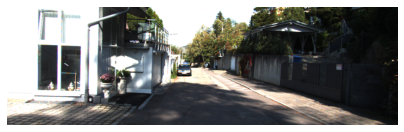

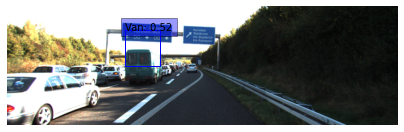

In [61]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

In [105]:
# 모델 가중치 확인
print("Number of model layers:", len(inference_model.layers))
print("Number of trainable weights:", len(inference_model.trainable_weights))
print("Model weights summary:")
inference_model.summary()


Number of model layers: 3
Number of trainable weights: 248
Model weights summary:
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
RetinaNet (RetinaNet)           (None, None, 12)     36554732    image[0][0]                      
__________________________________________________________________________________________________
decode_predictions (DecodePredi CombinedNonMaxSuppre 0           image[0][0]                      
                                                                 RetinaNet[0][0]                  
Total params: 36,554,732
Trainable params: 36,501,612
Non-trainable params: 53,120
__________________________

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_detections_claname(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=2, color=[0, 0, 1], font_size=12
):
    """
    이미지에 바운딩 박스와 클래스 텍스트를 시각화하는 함수입니다.
    """
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()

    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2  # matplotlib 좌표 체계에 맞게 조정
        w, h = x2 - x1, y2 - y1
        
        # 바운딩 박스 그리기
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        
        # 텍스트 표시 (배경과 폰트 크기 조정)
        ax.text(
            origin_x,
            origin_y - 10,  # 텍스트 위치를 박스 위로 약간 올림
            text,
            fontsize=font_size,  # 폰트 크기 설정
            color='yellow',  # 텍스트 색상을 노란색으로 변경
            bbox={"facecolor": 'black', "alpha": 0.6, "pad": 2},  # 검은 배경과 약간의 투명도 적용
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')


슝=3


학습 전 : 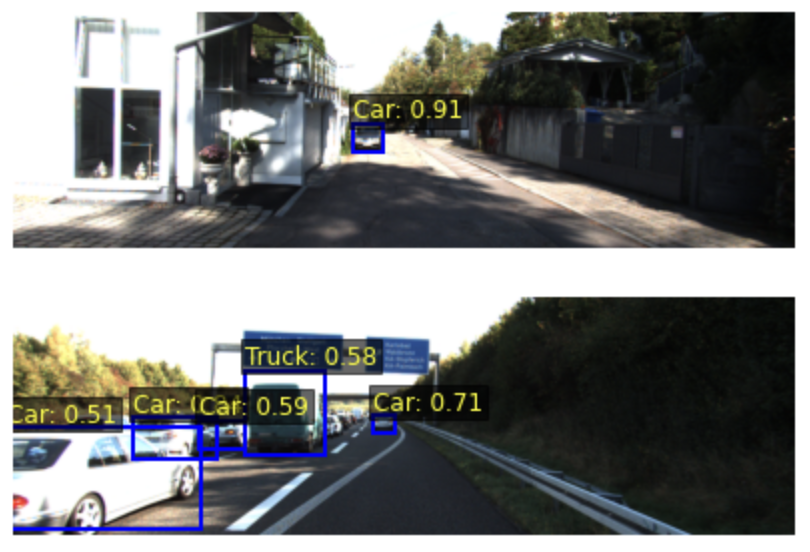
학습 후 : 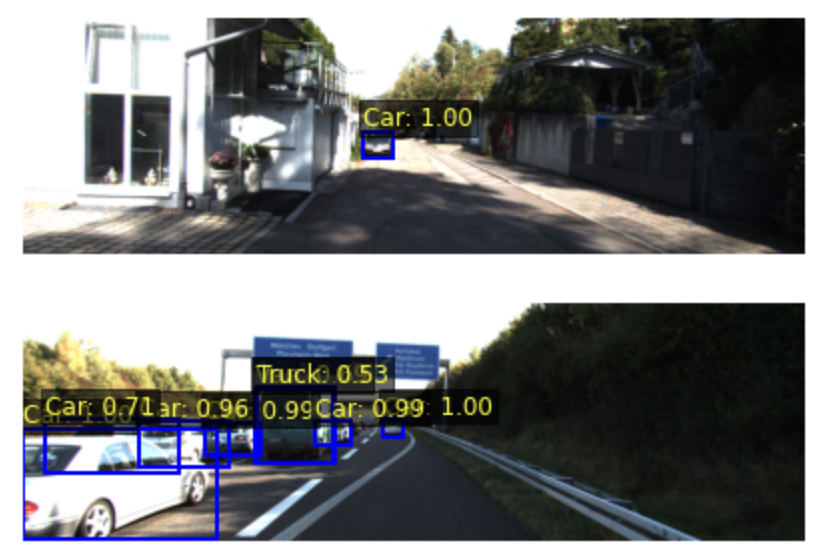

- car class 탐지 성능은 향상 (0.71->0.99)
- truck class 탐지 성능은 하락 (0.58 -> 0.53)
- car class만 과적합 되는건가?

# 회고

### 객체 탐지(Object Detection) 평가지표
- IoU, Precision, Recall, mAP

- 이미지의 해상도가 상당히 높기 때문에 학습 과정에서 많은 계산을 필요로 하며, 이는 학습 속도를 저하
- 해결 방법
1. 이미지 크기 줄이기 (리사이즈)
2. 배치 크기 줄이기
3. 데이터셋의 Prefetch 및 캐싱 사용

- min_side_range = [640, 1024]
- 학습 속도와 메모리 최적화를 위한 좋은 선택, 다만 모델의 성능에 미치는 영향
- min_side_range = [400, 600]
-> 하나만 적용했을 때는 속도 향상이 되지 않았으나, 이미지 사이즈 줄이고 +배치사이즈 늘려서 학습 했을 때 학습 속도 상승